In [2]:
import numpy as np
from qiskit.opflow import (
    Z,
    X,
    Y,
    I,
    Plus,
    Minus,
    Zero, One,
    CX, S, H, T, CZ, Swap,
    TensoredOp
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator, Pauli
I0 = (I + Z) / 2
I1 = (I - Z) / 2

# Shift Operator

One important circuit is the one that does the transformation |i> -> |i+1> in the computation basis, aka the shif operator

In [192]:
from typing import Optional, List, Union, Dict, Sequence
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.parameterexpression import ParameterValueType
from qiskit.circuit.register import Register
from qiskit.circuit.bit import Bit
from qiskit.quantum_info.operators import Operator
import numpy as np


class ShiftOperator(QuantumCircuit):

    def __init__(
        self,
        regs: Union[Register, int, Sequence[Bit]],
        name: Optional[str] = None,
        global_phase: ParameterValueType = 0,
        metadata: Optional[Dict] = None,
        use_mct_ancilla: bool = False
    ):

        self.qreg = QuantumRegister(regs)
        super().__init__(self.qreg)
        

        if not use_mct_ancilla:
            for i in reversed(range(1, self.num_qubits)):
                self.mct(self.qreg[:i], self.qreg[i])
            self.x(self.qreg[0])
        else:
            qreg_shift_ancilla = QuantumRegister(self.num_qubits-3, 'q_shift_ancilla')
            self.add_register(qreg_shift_ancilla)
            for i in reversed(range(1, self.num_qubits)):
                self.mct(self.qreg[:i], self.qreg[i], qreg_shift_ancilla, mode='v-chain')
            self.x(self.qreg[0])
            
s = ShiftOperator(3)
Padj = Operator(s).adjoint()
P = Operator(s)

Pmat = Operator(P).data.real
Padjmat = Operator(Padj).data.real

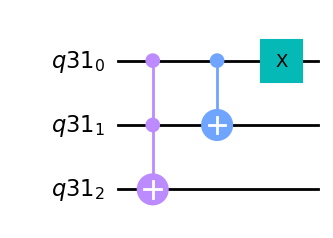

In [211]:
s.draw('mpl')

# Matrix to decompose

When considering a linear array where only the nearest neighbor interactions are inculded, the matrix of the linear system is:

In [4]:
import numpy as np
A0 = np. array([
       [ 384., -448.,    0.,    0.,    0.,    0.,    0.,   64.],
       [-448.,  896., -448.,    0.,    0.,    0.,    0.,    0.],
       [   0., -448.,  896., -448.,    0.,    0.,    0.,    0.],
       [   0.,    0., -448.,  896., -448.,    0.,    0.,    0.],
       [   0.,    0.,    0., -448.,  896., -448.,    0.,    0.],
       [   0.,    0.,    0.,    0., -448.,  896., -448.,    0.],
       [   0.,    0.,    0.,    0.,    0., -448.,  896., -448.],
       [  64.,    0.,    0.,    0.,    0.,    0., -448.,  384.]])

This matrix can be decomposed using unitaries/permuation matrix as:

In [135]:
a = 896*np.eye(8) - 448*(np.eye(8,k=1)+np.eye(8,k=-1))

I = np.eye(8)
b = np.eye(8)
b[0,0] = b[7,7] = -1

c = np.eye(8)
c[0,0] = c[7,7] = 0 
c[0,7] = c[7,0] = -1

a  - 448/2*I + (448/2+64)*b - c * 64

array([[ 384., -448.,    0.,    0.,    0.,    0.,    0.,   64.],
       [-448.,  896., -448.,    0.,    0.,    0.,    0.,    0.],
       [   0., -448.,  896., -448.,    0.,    0.,    0.,    0.],
       [   0.,    0., -448.,  896., -448.,    0.,    0.,    0.],
       [   0.,    0.,    0., -448.,  896., -448.,    0.,    0.],
       [   0.,    0.,    0.,    0., -448.,  896., -448.,    0.],
       [   0.,    0.,    0.,    0.,    0., -448.,  896., -448.],
       [  64.,    0.,    0.,    0.,    0.,    0., -448.,  384.]])

The matrix $a$ can be written as :

In [195]:
448*(I + np.abs(c) + (I-b)/2 - Pmat - Padjmat)

array([[ 896., -448.,    0.,    0.,    0.,    0.,    0.,    0.],
       [-448.,  896., -448.,    0.,    0.,    0.,    0.,    0.],
       [   0., -448.,  896., -448.,    0.,    0.,    0.,    0.],
       [   0.,    0., -448.,  896., -448.,    0.,    0.,    0.],
       [   0.,    0.,    0., -448.,  896., -448.,    0.,    0.],
       [   0.,    0.,    0.,    0., -448.,  896., -448.,    0.],
       [   0.,    0.,    0.,    0.,    0., -448.,  896., -448.],
       [   0.,    0.,    0.,    0.,    0.,    0., -448.,  896.]])

Leading to 

In [196]:
448 * (I - Pmat - Padjmat + np.abs(c)) + 64 * b - 64*c 

array([[ 384., -448.,    0.,    0.,    0.,    0.,    0.,   64.],
       [-448.,  896., -448.,    0.,    0.,    0.,    0.,    0.],
       [   0., -448.,  896., -448.,    0.,    0.,    0.,    0.],
       [   0.,    0., -448.,  896., -448.,    0.,    0.,    0.],
       [   0.,    0.,    0., -448.,  896., -448.,    0.,    0.],
       [   0.,    0.,    0.,    0., -448.,  896., -448.,    0.],
       [   0.,    0.,    0.,    0.,    0., -448.,  896., -448.],
       [  64.,    0.,    0.,    0.,    0.,    0., -448.,  384.]])

# Quantum circuit for $b$
The matrix $b$ is given by: 

In [197]:
b

array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

This matrix can be encoded in the following circuit

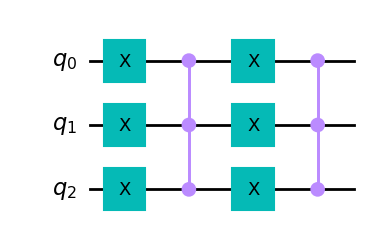

In [220]:
qc_b = QuantumCircuit(3)
qc_b.x(0)
qc_b.x(1)
qc_b.x(2)
qc_b.ccz(0,1,2)
qc_b.x(0)
qc_b.x(1)
qc_b.x(2)
qc_b.ccz(0,1,2)
qc_b.draw('mpl')


In [221]:
Operator(qc_b).data.real

array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

# Quantum circuit for $c$
The matrix $c$ is given by 

In [200]:
c

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

This matrix can be encoded in the following circuit

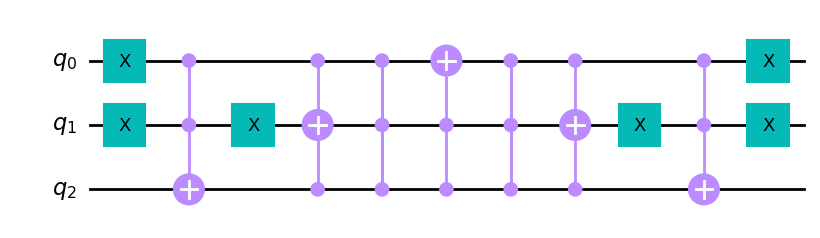

In [208]:
qc_c = QuantumCircuit(3)
qc_c.x(0)
qc_c.x(1)
qc_c.ccx(0,1,2)
# qc.x(0)
qc_c.x(1)

# qc.x(0)
qc_c.ccx(0,2,1)
# qc_c.x(0)

qc_c.ccz(1,2,0)
qc_c.ccx(1,2,0)
qc_c.ccz(1,2,0)

# qc_c.x(0)
qc_c.ccx(0,2,1)
# qc.x(0)

# qc.x(0)
qc_c.x(1)
qc_c.ccx(0,1,2)
qc_c.x(0)
qc_c.x(1)

qc_c.draw('mpl')


In [209]:
Operator(qc_c).data.real

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

# Quantum circuit for $|c|$
The matrix $|c|$ is given by: 

In [203]:
np.abs(c)

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

This matrix can be encoded in the follwoing circuit:

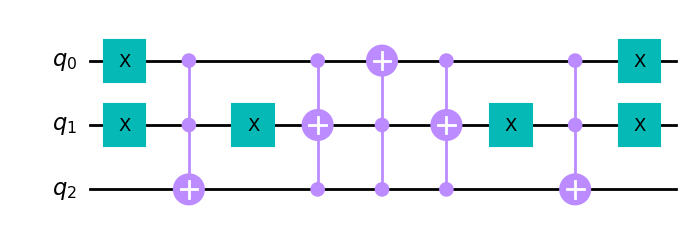

In [206]:
qc_absc = QuantumCircuit(3)
qc_absc.x(0)
qc_absc.x(1)
qc_absc.ccx(0,1,2)
# qc.x(0)
qc_absc.x(1)

# qc.x(0)
qc_absc.ccx(0,2,1)
# qc_absc.x(0)

# qc_c.ccz(1,2,0)
qc_absc.ccx(1,2,0)
# qc_c.ccz(1,2,0)

# qc_absc.x(0)
qc_absc.ccx(0,2,1)
# qc.x(0)

# qc.x(0)
qc_absc.x(1)
qc_absc.ccx(0,1,2)
qc_absc.x(0)
qc_absc.x(1)

qc_absc.draw('mpl')


In [207]:
Operator(qc_absc).data.real

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [188]:
448*(I + np.abs(c) + (I-b)/2 - Operator(P).data.real - Operator(Padj).data.real)

array([[ 896., -448.,    0.,    0.,    0.,    0.,    0.,    0.],
       [-448.,  896., -448.,    0.,    0.,    0.,    0.,    0.],
       [   0., -448.,  896., -448.,    0.,    0.,    0.,    0.],
       [   0.,    0., -448.,  896., -448.,    0.,    0.,    0.],
       [   0.,    0.,    0., -448.,  896., -448.,    0.,    0.],
       [   0.,    0.,    0.,    0., -448.,  896., -448.,    0.],
       [   0.,    0.,    0.,    0.,    0., -448.,  896., -448.],
       [   0.,    0.,    0.,    0.,    0.,    0., -448.,  896.]])

In [29]:
Aeven = Operator(I^I^(I-X))
Aodd = Padj.compose(Operator(I^I^(I-X))).compose(P) 
Aper = Operator(I^I^(I-X)) + Padj.compose(I^I^(I-X)).compose(P)
Adir = Aper + P.compose(I0^I0^X).compose(Padj) 
Aneu = Aper - P.compose(I0^I0^(I-X)).compose(Padj)

In [32]:
from pauli_decomp import PauliDecomposition 
pd = PauliDecomposition((P.compose(I0^I0^X).compose(Padj) ).data.real)
pd.paulis

{'XXX': (0.25+0j), 'XYY': (-0.25+0j), 'YXY': (-0.25+0j), 'YYX': (-0.25+0j)}

In [7]:
from qiskit.circuit.library import CCZGate 
P07 = np.eye(8)
P07[0,0] = 0
P07[0,7] = 1
P07[7,7] = 0
P07[7,0] = 1

Operator(CCZGate()).data.real@P07@Aodd.data.real

array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [8]:
from qiskit.circuit.library import Permutation 
qc=Permutation(3,[1,0,2])
# qc.decompose().draw('mpl')
Operator(qc).data.real


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

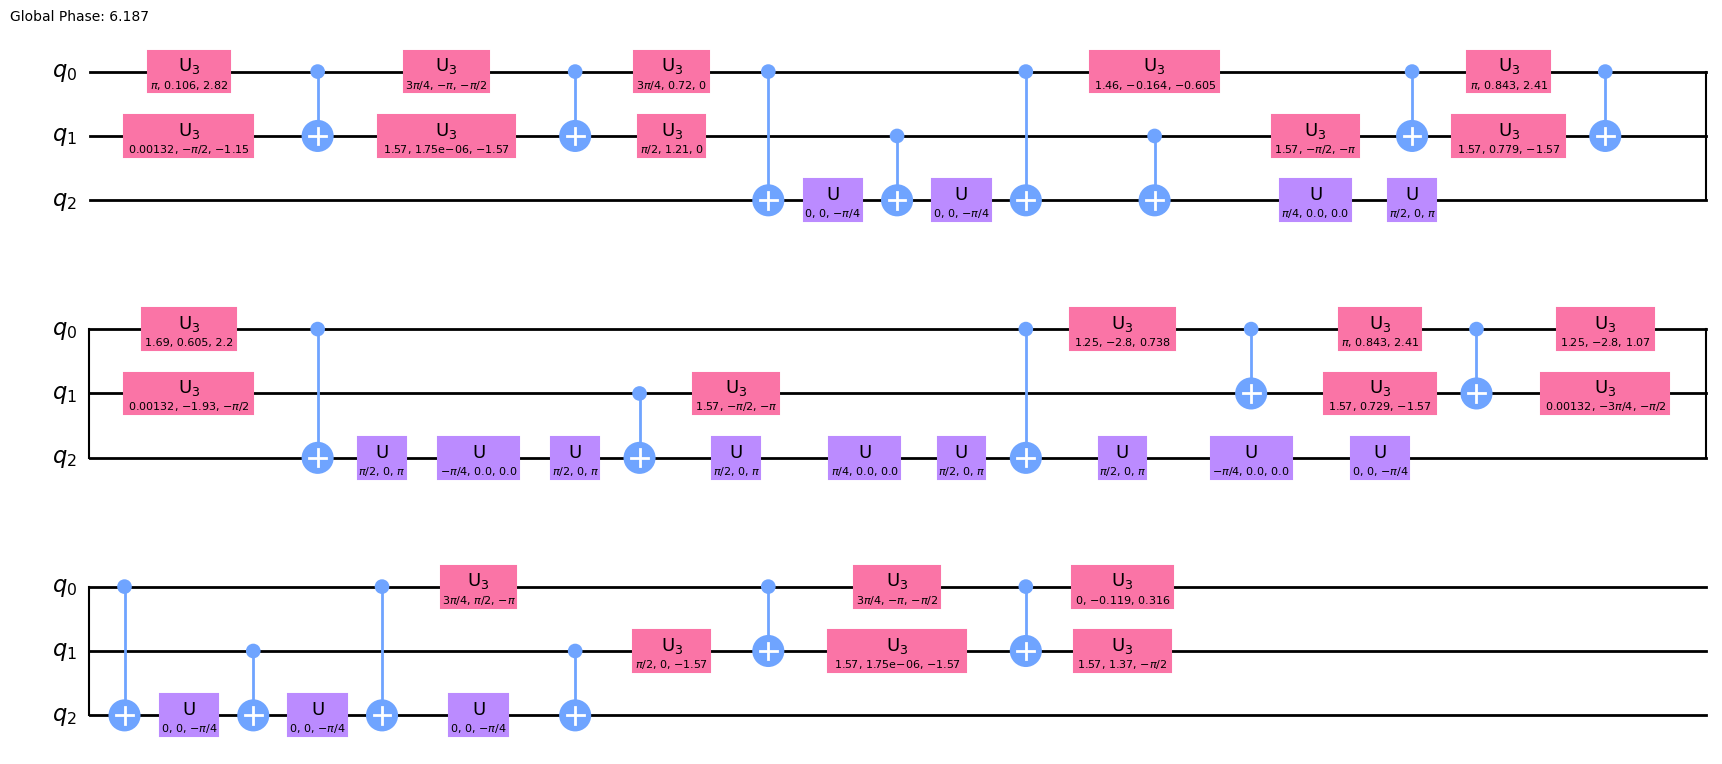

In [9]:
from qiskit.compiler import transpile 
from qiskit import QuantumCircuit 
qc = QuantumCircuit(3)
qc.unitary(P07,[0,1,2])
tqc = transpile(qc, optimization_level=3)
tqc.decompose().draw('mpl')


In [41]:
qc = QuantumCircuit(2)
# qc.x(1)
qc.cx(0,1)
qc.x(0)
# qc.cx(1,0)
# qc.x(0)
# qc.cx(0,1)
# qc.x(0)
Operator(qc).data.real

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [80]:
qc = QuantumCircuit(2)
# qc.x(1)
qc.cx(0,1)
qc.x(0)
Operator(qc).data.real

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

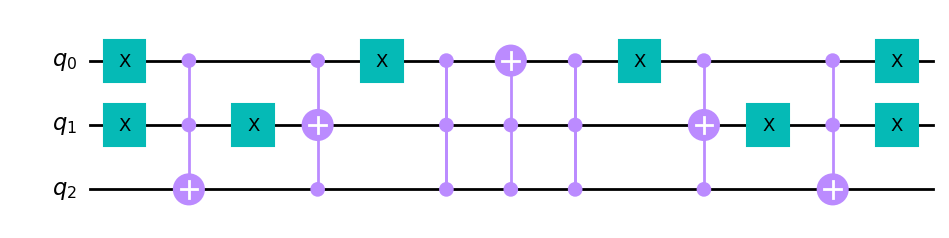

In [102]:
qc = QuantumCircuit(3)
qc.x(0)
qc.x(1)
qc.ccx(0,1,2)
# qc.x(0)
qc.x(1)

# qc.x(0)
qc.ccx(0,2,1)
qc.x(0)

qc.ccz(1,2,0)
qc.ccx(1,2,0)
qc.ccz(1,2,0)

qc.x(0)
qc.ccx(0,2,1)
# qc.x(0)

# qc.x(0)
qc.x(1)
qc.ccx(0,1,2)
qc.x(0)
qc.x(1)

qc.draw('mpl')




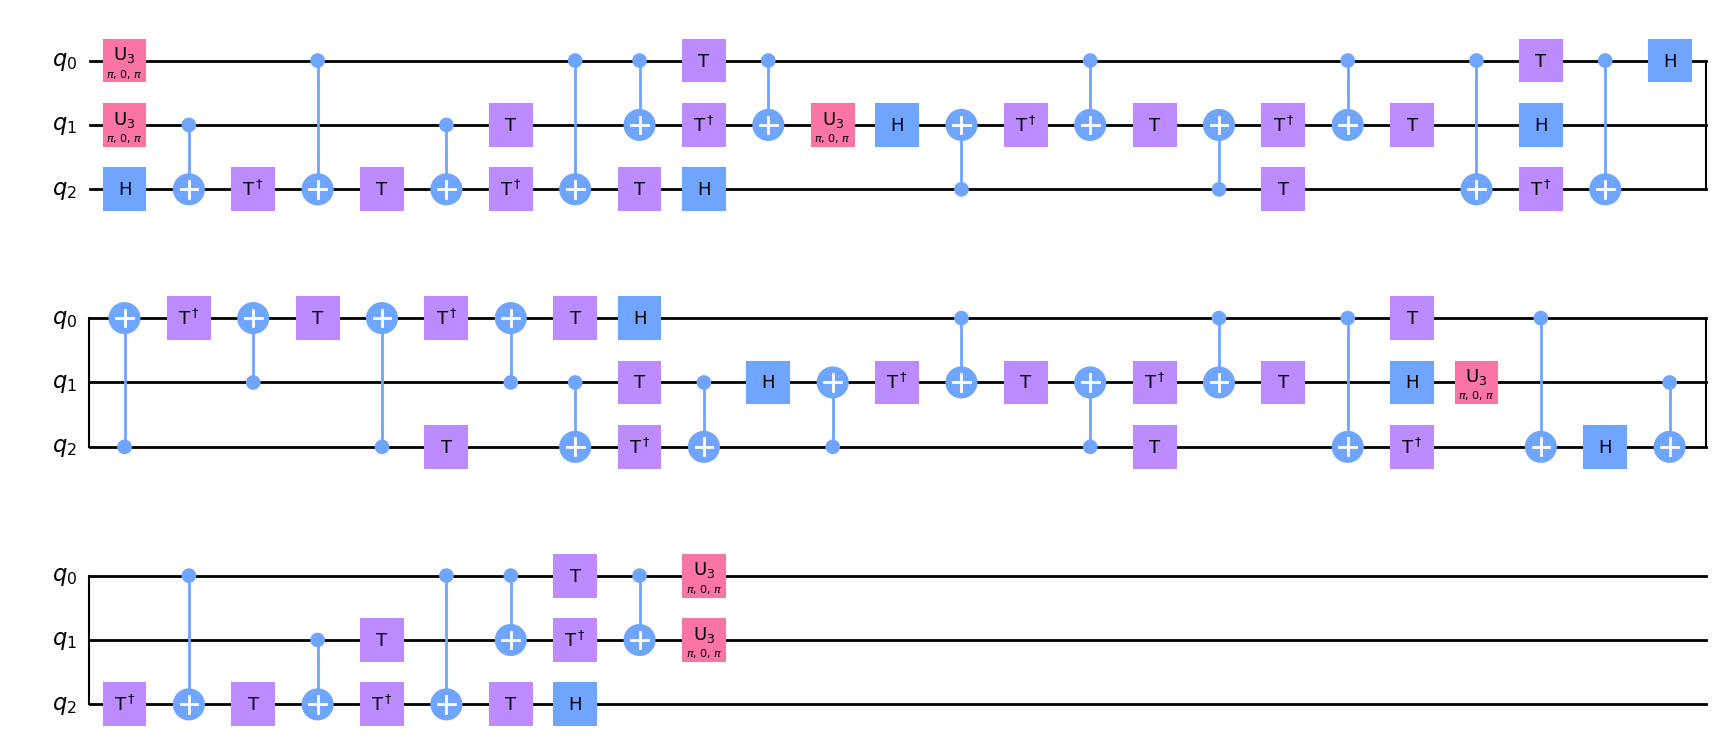

In [98]:
tqc = transpile(qc)
tqc.decompose().draw('mpl')

In [85]:
# qc = LinearFunction([[1,1],[0,1]]).synthesize()
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(1,0)
qc.x(0)
# qc.x(1)
qc.draw('mpl')
Operator(qc).data.real #@np.array([[0],[1],[0],[0]])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [86]:
qc = QuantumCircuit(2)
# qc.x(0)
qc.cx(1,0)
# qc.x(0)
Operator(qc).data.real

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [101]:
qc = QuantumCircuit(1)
qc.z(0)
qc.x(0)
qc.z(0)

Operator(qc).data.real

array([[ 0., -1.],
       [-1.,  0.]])

In [176]:
- Operator(P).data.real - Operator(Padj).data.real 

array([[-0., -1., -0., -0., -0., -0., -0., -1.],
       [-1., -0., -1., -0., -0., -0., -0., -0.],
       [-0., -1., -0., -1., -0., -0., -0., -0.],
       [-0., -0., -1., -0., -1., -0., -0., -0.],
       [-0., -0., -0., -1., -0., -1., -0., -0.],
       [-0., -0., -0., -0., -1., -0., -1., -0.],
       [-0., -0., -0., -0., -0., -1., -0., -1.],
       [-1., -0., -0., -0., -0., -0., -1., -0.]])

In [175]:
 -(I+c) - (I-b)/2 - Operator(P).data.real - Operator(Padj).data.real

array([[-2., -1., -0., -0., -0., -0., -0.,  0.],
       [-1., -2., -1., -0., -0., -0., -0., -0.],
       [-0., -1., -2., -1., -0., -0., -0., -0.],
       [-0., -0., -1., -2., -1., -0., -0., -0.],
       [-0., -0., -0., -1., -2., -1., -0., -0.],
       [-0., -0., -0., -0., -1., -2., -1., -0.],
       [-0., -0., -0., -0., -0., -1., -2., -1.],
       [ 0., -0., -0., -0., -0., -0., -1., -2.]])

In [184]:
I + np.abs(c) + (I-b)/2 - Operator(P).data.real - Operator(Padj).data.real 

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

In [171]:
I+c + (I-b)/2

array([[ 2.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]])

In [169]:
(I-b)/2

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])